# 基于用户的协同过滤推荐

In [8]:
# 导入包
import random
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 一. 通用函数定义

In [9]:
# 定义装饰器，监控运行时间
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()#开始时间
        res = func(*args, **kwargs)
        stop_time = time.time()#结束时间
        print('Func %s, run time: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

### 1. 数据处理相关
1. load data
2. split data

In [10]:
class Dataset():
    
    def __init__(self, fp):
        # fp: data file path
        self.data = self.loadData(fp)
    
    def loadData(self, fp):
        data = []
        for l in open(fp):
            data.append(tuple(map(int, l.strip().split('::')[:2]))) #删除数据头部和尾部的空白符号并按照‘::’进行分割，取分割后列表的头两个元素并将其转换为 int型列表，最后再将该列表转换为元组，并添加至data列表中 例如 [(1,2),(3,4)]
        return data
    
    def splitData(self, M, k, seed=1):
        '''
        :params: data, 加载的所有(user, item)数据条目
        :params: M, 划分的数目,最后需要取 M折的平均
        :params: k, 本次是第几次划分,k~[0, M)
        :params: seed, random的种子数,对于不同的k应设置成一样的
        :return: train, test
        '''
        train, test = [], [] #划分训练集和测试集
        random.seed(seed) #改变随机数生成器的种子
        for user, item in self.data:
            # 这里与书中的不一致，本人认为取M-1较为合理，因randint是左右都覆盖的
            if random.randint(0, M-1) == k:  
                test.append((user, item))
            else:
                train.append((user, item))

        # 处理成字典的形式，user->set(items) {UserID1:{MovieID1},UserID2:{MovieID2}}
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                if user not in data_dict:
                    data_dict[user] = set()
                data_dict[user].add(item)
            data_dict = {k: list(data_dict[k]) for k in data_dict} #将{UserID1:{MovieID1},UserID2:{MovieID2}}==>{UserID1:[MovieID1],UserID2:[MovieID2]}
            return data_dict

        return convert_dict(train), convert_dict(test)

### 2. 评价指标
1. Precision（精确率）
2. Recall（召回率）
3. Coverage（覆盖率）
4. Popularity(Novelty)（新颖度）

In [11]:
class Metric():
    
    def __init__(self, train, test, GetRecommendation):
        '''
        :params: train, 训练数据
        :params: test, 测试数据
        :params: GetRecommendation, 为某个用户获取推荐物品的接口函数
        '''
        self.train = train
        self.test = test
        self.GetRecommendation = GetRecommendation
        self.recs = self.getRec()
        
    # 为test中的每个用户进行推荐
    def getRec(self):
        recs = {}
        for user in self.test:
            rank = self.GetRecommendation(user)
            recs[user] = rank
        return recs
        
    # 定义精确率指标计算方式
    def precision(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(rank)
        return round(hit / all * 100, 2)
    
    # 定义召回率指标计算方式
    def recall(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(test_items)
        return round(hit / all * 100, 2)
    
    # 定义覆盖率指标计算方式
    def coverage(self):
        all_item, recom_item = set(), set()
        for user in self.test:
            for item in self.train[user]:
                all_item.add(item)
            rank = self.recs[user]
            for item, score in rank:
                recom_item.add(item)
        return round(len(recom_item) / len(all_item) * 100, 2)
    
    # 定义新颖度指标计算方式
    def popularity(self):
        # 计算物品的流行度
        item_pop = {}
        for user in self.train:
            for item in self.train[user]:
                if item not in item_pop:
                    item_pop[item] = 0
                item_pop[item] += 1

        num, pop = 0, 0
        for user in self.test:
            rank = self.recs[user]
            for item, score in rank:
                # 取对数，防止因长尾问题带来的被流行物品所主导
                pop += math.log(1 + item_pop[item])
                num += 1
        return round(pop / num, 6)
    
    def eval(self):
        metric = {'Precision': self.precision(),
                  'Recall': self.recall(),
                  'Coverage': self.coverage(),
                  'Popularity': self.popularity()}
        print('Metric:', metric)
        return metric

## 二. 算法实现
1. UserCF
2. UserIIF

In [12]:
# 1. 基于用户余弦相似度的推荐
def UserCF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数,设置取TopK相似用户数目
    :params: N, 超参数,设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算item->user的倒排索引
    item_users = {}
    for user in train:
        for item in train[user]:
            if item not in item_users:
                item_users[item] = []
            item_users[item].append(user)
    
    # 计算用户兴趣相似度
    sim = {}
    num = {}
    for item in item_users:
        users = item_users[item]
        for i in range(len(users)):
            u = users[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(users)):
                if j == i: continue
                v = users[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                sim[u][v] += 1
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v]) #用户U和用户V的兴趣相似度
    
    # 按照相似度排序
    sorted_user_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for u, _ in sorted_user_sim[user][:K]:
            for item in train[u]:
                # 要去掉用户见过的
                if item not in seen_items:
                    if item not in items:
                        items[item] = 0
                    items[item] += sim[user][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

## 三. 实验
1. Random实验
2. MostPopular实验
3. UserCF实验，K=[5, 10, 20, 40, 80, 160]

M=8, N=10

In [13]:
metricList1=[] #存放平均数据

In [14]:
class Experiment():
    
    def __init__(self, M, K, N, fp='../dataset/ml-1m/ratings.dat', rt='UserCF'):
        '''
        :params: M, 进行多少次实验
        :params: K, TopK相似用户的个数
        :params: N, TopN推荐物品的个数
        :params: fp, 数据文件路径
        :params: rt, 推荐算法类型
        '''
        self.M = M
        self.K = K
        self.N = N
        self.fp = fp
        self.rt = rt
        self.alg = {'UserCF': UserCF}
    
    # 定义单次实验
    @timmer
    def worker(self, train, test):
        '''
        :params: train, 训练数据集
        :params: test, 实验数据集
        :return: 各指标的值
        '''
        getRecommendation = self.alg[self.rt](train, self.K, self.N)#调用UserCF函数
        metric = Metric(train, test, getRecommendation)
        return metric.eval()
    
    # 多次实验取平均
    @timmer
    def run(self):
        metrics = {'Precision': 0, 'Recall': 0, 'Coverage': 0, 'Popularity': 0} #衡量标准
        metricList = []

        dataset = Dataset(self.fp) #处理训练集的数据
        for ii in range(self.M):
            train, test = dataset.splitData(self.M, ii)
            print('-------------------------Experiment {}-------------------------'.format(ii))
            metric = self.worker(train, test) #调用单次实验
            metricList.append(metric)#将数据存储
            metrics = {k: metrics[k]+metric[k] for k in metrics}#将同一类的元素相加
        metrics = {k: metrics[k] / self.M for k in metrics} #求得各评测指标的平均值
        metricList1.append(metrics)
        print('Average Result (M={}, K={}, N={}): {}'.format(self.M, self.K, self.N, metrics))
        df = pd.DataFrame(metricList)#以表格形式呈现

        fig, ax = plt.subplots() # 创建图实例
        x = np.arange(1,9)
        y1,y2,y3,y4=[],[],[],[]
        for met in metricList:
            y1.append(met['Precision'])
            y2.append(met['Recall'])
            y3.append(met['Coverage'])
            y4.append(met['Popularity'])
        ax.plot(x,y1,label='Precision')
        ax.plot(x,y2,label='Recall')
        ax.plot(x,y3,label='Coverage')
        ax.plot(x,y4,label='Popularity')
        ax.set_xlabel('Number of experiments') #设置x轴名称 Number of experiments
        ax.set_title('Simple Plot') #设置图名为Simple Plot
        ax.legend() #自动检测要在图例中显示的元素，并且显示

        plt.show() #图形可视化

        return df

-------------------------Experiment 0-------------------------
Metric: {'Precision': 16.91, 'Recall': 8.12, 'Coverage': 52.36, 'Popularity': 6.819158}
Func worker, run time: 75.48834228515625
-------------------------Experiment 1-------------------------
Metric: {'Precision': 17.05, 'Recall': 8.16, 'Coverage': 52.03, 'Popularity': 6.815594}
Func worker, run time: 74.41063451766968
-------------------------Experiment 2-------------------------
Metric: {'Precision': 16.91, 'Recall': 8.09, 'Coverage': 51.69, 'Popularity': 6.818892}
Func worker, run time: 74.95457482337952
-------------------------Experiment 3-------------------------
Metric: {'Precision': 16.95, 'Recall': 8.15, 'Coverage': 52.11, 'Popularity': 6.817726}
Func worker, run time: 75.41245675086975
-------------------------Experiment 4-------------------------
Metric: {'Precision': 17.06, 'Recall': 8.2, 'Coverage': 52.14, 'Popularity': 6.821423}
Func worker, run time: 75.38734006881714
-------------------------Experiment 5----

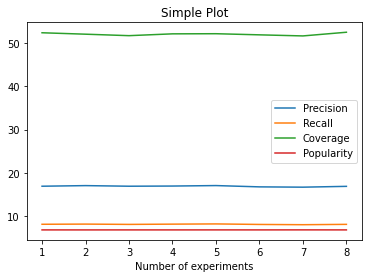

Func run, run time: 605.0693085193634
   Precision  Recall  Coverage  Popularity
0      16.91    8.12     52.36    6.819158
1      17.05    8.16     52.03    6.815594
2      16.91    8.09     51.69    6.818892
3      16.95    8.15     52.11    6.817726
4      17.06    8.20     52.14    6.821423
5      16.76    8.08     51.88    6.818674
6      16.69    8.02     51.63    6.824730
7      16.88    8.10     52.48    6.819526
-------------------------Experiment 0-------------------------
Metric: {'Precision': 20.52, 'Recall': 9.86, 'Coverage': 41.95, 'Popularity': 6.982281}
Func worker, run time: 74.5045895576477
-------------------------Experiment 1-------------------------
Metric: {'Precision': 20.47, 'Recall': 9.8, 'Coverage': 42.03, 'Popularity': 6.97276}
Func worker, run time: 74.44136238098145
-------------------------Experiment 2-------------------------
Metric: {'Precision': 20.61, 'Recall': 9.85, 'Coverage': 41.57, 'Popularity': 6.980271}
Func worker, run time: 75.37579345703125
--

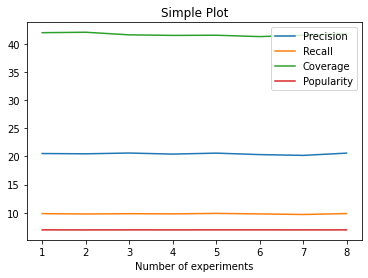

Func run, run time: 607.3979775905609
   Precision  Recall  Coverage  Popularity
0      20.52    9.86     41.95    6.982281
1      20.47    9.80     42.03    6.972760
2      20.61    9.85     41.57    6.980271
3      20.42    9.82     41.47    6.978843
4      20.59    9.90     41.50    6.980595
5      20.33    9.81     41.26    6.981309
6      20.19    9.71     41.49    6.976377
7      20.59    9.87     41.80    6.980998
-------------------------Experiment 0-------------------------
Metric: {'Precision': 23.11, 'Recall': 11.1, 'Coverage': 32.6, 'Popularity': 7.1045}
Func worker, run time: 77.4698052406311
-------------------------Experiment 1-------------------------
Metric: {'Precision': 22.96, 'Recall': 10.99, 'Coverage': 33.0, 'Popularity': 7.094808}
Func worker, run time: 77.17454266548157
-------------------------Experiment 2-------------------------
Metric: {'Precision': 23.2, 'Recall': 11.09, 'Coverage': 32.1, 'Popularity': 7.101388}
Func worker, run time: 76.9075927734375
-----

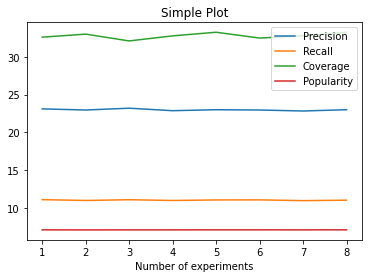

Func run, run time: 624.2239000797272
   Precision  Recall  Coverage  Popularity
0      23.11   11.10     32.60    7.104500
1      22.96   10.99     33.00    7.094808
2      23.20   11.09     32.10    7.101388
3      22.87   10.99     32.77    7.101266
4      23.00   11.06     33.25    7.103770
5      22.96   11.07     32.48    7.104060
6      22.83   10.97     32.79    7.100858
7      23.00   11.03     33.24    7.108260
-------------------------Experiment 0-------------------------
Metric: {'Precision': 24.73, 'Recall': 11.88, 'Coverage': 25.8, 'Popularity': 7.204384}
Func worker, run time: 80.68451690673828
-------------------------Experiment 1-------------------------
Metric: {'Precision': 24.66, 'Recall': 11.81, 'Coverage': 26.03, 'Popularity': 7.19405}
Func worker, run time: 81.42308068275452
-------------------------Experiment 2-------------------------
Metric: {'Precision': 24.68, 'Recall': 11.8, 'Coverage': 25.66, 'Popularity': 7.20158}
Func worker, run time: 81.23982572555542


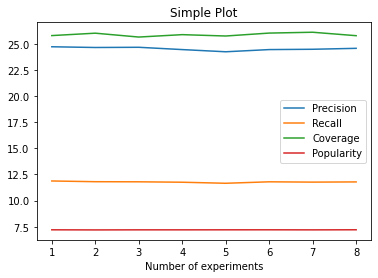

Func run, run time: 667.8962829113007
   Precision  Recall  Coverage  Popularity
0      24.73   11.88     25.80    7.204384
1      24.66   11.81     26.03    7.194050
2      24.68   11.80     25.66    7.201580
3      24.46   11.76     25.89    7.201308
4      24.25   11.66     25.76    7.204154
5      24.46   11.80     26.04    7.205482
6      24.49   11.77     26.12    7.199023
7      24.58   11.79     25.79    7.207737


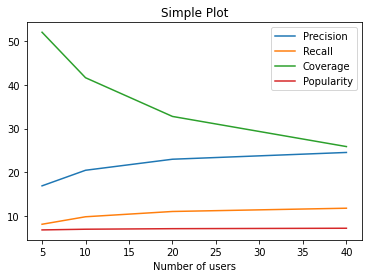

In [15]:
# 1. UserCF实验
M, N = 8, 10 #M：试验次数 N：推荐物品的个数 K：相似用户的个数
for K in [5,10,20,40]:
    cf_exp = Experiment(M, K, N, rt='UserCF')
    df = cf_exp.run()
    print(df)

x11=[5,10,20,40]
y11,y22,y33,y44=[],[],[],[]
for i in metricList1:
    y11.append(i['Precision'])
    y22.append(i['Recall'])
    y33.append(i['Coverage'])
    y44.append(i['Popularity'])

fig,ax=plt.subplots()
ax.plot(x11,y11,label='Precision')
ax.plot(x11,y22,label='Recall')
ax.plot(x11,y33,label='Coverage')
ax.plot(x11,y44,label='Popularity')
ax.set_xlabel('Number of users')
ax.set_title('Simple Plot') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示

plt.show()

## 五. 总结
1. 数据集分割的小技巧，用同样的seed
2. 各个指标的实现，要注意
3. 为每个用户推荐的时候是推荐他们**没有见过**的，因为实验集里面是这样的
4. 倒排物品-用户索引，可进行时间优化
5. 推荐的时候K和N各代表什么意思，要分开设置，先取TopK，然后取TopN